In [1]:
#from ultralytics.utils.callbacks.base import on_predict_end
# Check GPU type
!nvidia-smi

Mon Dec  9 07:09:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   21C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install ultralytics
!pip -q install  ultralytics

In [4]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing


In [5]:
# get data from s3

# Create directories in standard python environment
os.makedirs('./dataset', exist_ok=True)
os.makedirs('./images', exist_ok=True)
os.makedirs('./data', exist_ok=True)

# download the data
!aws s3 cp s3://crop-diseases/images.zip ./data
!aws s3 cp s3://crop-diseases/Train.csv ./data
!aws s3 cp s3://crop-diseases/Test.csv ./data
!aws s3 cp s3://crop-diseases/SampleSubmission.csv ./data


Completed 3.1 GiB/10.4 G^C (291.1 MiB/s) with 1 file(s) remaining   
download: s3://crop-diseases/Train.csv to data/Train.csv        g   
download: s3://crop-diseases/Test.csv to data/Test.csv            
download: s3://crop-diseases/SampleSubmission.csv to data/SampleSubmission.csv


In [5]:
# Set up directories for training a yolo model

DATA_DIR = Path('data')

# Images directories
DATASET_DIR = Path('dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [36]:
# Unzip images to 'images' dir
shutil.unpack_archive(DATA_DIR / 'images.zip', 'images')

In [7]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
class_mapper = {x:y for x,y in zip(sorted(train['class'].unique().tolist()), range(train['class'].nunique()))}
train['class_id'] = train['class'].map(class_mapper)

# Preview the head of the train set
train.head()

Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax            image_path  class_id  
0   208.107730   341.967928  images/id_11543h.jpg         5  
1   162.910362   266.195724  images/id_11543h.jpg         5  
2   252.712993   338.876645  images/id_11543h.jpg         5  
3   238.593750   354.651316  images/id_11543h.jpg         5  
4  2184.252196  1401.748952  images/id_11ee1c.jpg         8

In [8]:
test.head()

Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
4  id_14tw4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

             image_path  
0  images/id_128pxx.jpg  
1  images/id_12jbci.jpg  
2  images/id_143s4o.jpg  
3  images/id_14tfmb.jpg  
4  images/id_14tw4o.jpg

In [9]:
ss.head()

Image_ID                      class  confidence  ymin  xmin  ymax  \
0  id_128pxx.jpg  Corn_Cercospora_Leaf_Spot         0.5   100   100   100   
1  id_128pxx.jpg           Corn_Common_Rust         0.5   100   100   100   
2  id_128pxx.jpg               Corn_Healthy         0.5   100   100   100   
3  id_128pxx.jpg  Corn_Northern_Leaf_Blight         0.5   100   100   100   
4  id_128pxx.jpg                Corn_Streak         0.5   100   100   100   

   xmax  
0   100  
1   100  
2   100  
3   100  
4   100

In [10]:
# create more images from the transforms to balance out the other classes

import os
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms.functional import hflip, rotate
import random

# Define the transformation pipeline
transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(60),
    T.ToTensor()
])

# Helper function to transform bounding boxes
def transform_bounding_box(bbox, image_size, transform_fn):
    """
    Transform a bounding box according to the given transformation function.

    Args:
        bbox (dict): Bounding box with keys ['xmin', 'ymin', 'xmax', 'ymax'].
        image_size (tuple): Size of the image (width, height).
        transform_fn (callable): A function that applies the same transformation to coordinates.

    Returns:
        dict: Transformed bounding box.
    """
    # Extract coordinates
    xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
    width, height = image_size

    # Define corner points of the bounding box
    corners = np.array([
        [xmin, ymin],
        [xmax, ymin],
        [xmax, ymax],
        [xmin, ymax]
    ])

    # Apply transformation to each corner
    transformed_corners = np.array([transform_fn(pt, width, height) for pt in corners])

    # Recalculate bounding box
    x_coords = transformed_corners[:, 0]
    y_coords = transformed_corners[:, 1]
    transformed_bbox = {
        'xmin': min(x_coords),
        'ymin': min(y_coords),
        'xmax': max(x_coords),
        'ymax': max(y_coords)
    }
    return transformed_bbox

# Define specific coordinate transformation functions
def horizontal_flip(pt, width, _):
    """Flip a point horizontally."""
    return [width - pt[0], pt[1]]

def rotation(pt, width, height, angle):
    """Rotate a point around the image center."""
    cx, cy = width / 2, height / 2
    x, y = pt[0] - cx, pt[1] - cy
    rad = np.radians(angle)
    cos_a, sin_a = np.cos(rad), np.sin(rad)
    x_rot = cos_a * x - sin_a * y + cx
    y_rot = sin_a * x + cos_a * y + cy
    return [x_rot, y_rot]

# Function to apply transformations and save images
def save_transformed_images(train_set, output_dir, num_images=2):
    """
    Apply transformations to an image multiple times and save each result as a new image.

    Args:
        train_set (DataFrame): Training dataset with image paths and bounding boxes.
        output_dir (str): Directory where transformed images will be saved.
        num_images (int): Number of transformed images to generate per original image.

    Returns:
        DataFrame: Updated training dataset with new images.
    """
    os.makedirs(output_dir, exist_ok=True)
    new_train_data = train_set.copy()

    for index, row in train_set.iterrows():
        data = row.to_dict()
        original_image = Image.open(data['image_path']).convert("RGB")
        image_size = original_image.size  # (width, height)

        for _ in range(num_images):
            # Randomly choose a transformation
            transformed_image = original_image.copy()
            bbox = {
                'xmin': data['xmin'],
                'ymin': data['ymin'],
                'xmax': data['xmax'],
                'ymax': data['ymax']
            }
            transformed_bbox = bbox.copy()

            # Apply Horizontal Flip
            if random.random() < 0.5:
                transformed_image = hflip(transformed_image)
                transformed_bbox = transform_bounding_box(bbox, image_size, horizontal_flip)

            # Apply Rotation
            angle = random.uniform(-60, 60)
            transformed_image = rotate(transformed_image, angle)
            transformed_bbox = transform_bounding_box(bbox, image_size, lambda pt, w, h: rotation(pt, w, h, angle))

            # Save the transformed image
            file_name = os.path.splitext(os.path.basename(data['image_path']))[0]
            new_file_name = f"{file_name}_{np.random.randint(1, 1000)}.jpg"
            output_path = os.path.join(output_dir, new_file_name)
            transformed_image.save(output_path)

            # Append the new data
            new_train_data = pd.concat([
                new_train_data,
                pd.DataFrame({
                    'Image_ID': [new_file_name],
                    'class': [data['class']],
                    'confidence': [data['confidence']],
                    'ymin': [transformed_bbox['ymin']],
                    'xmin': [transformed_bbox['xmin']],
                    'ymax': [transformed_bbox['ymax']],
                    'xmax': [transformed_bbox['xmax']],
                    'image_path': [output_path],
                    'class_id': [data['class_id']]
                })
            ], ignore_index=True)

            print(f"Saved: {output_path}")

    return new_train_data


In [41]:
# Preview target distribution, seems there a class imbalance that needs to be handled
# Get normalized value counts and convert to DataFrame
train_class_distribution = train['class'].value_counts(normalize=True).reset_index()
train_class_distribution.columns = ['class', 'proportion']

# Combine both into a single DataFrame for comparison
class_distribution_df = pd.DataFrame(
    train_class_distribution,
)

# Fill NaN values with 0 (in case a class is missing in train or val)
class_distribution_df.fillna(0, inplace=True)
class_distribution_df.head()



class  proportion
0  Corn_Cercospora_Leaf_Spot    0.159351
1            Tomato_Septoria    0.158010
2         Tomato_Late_Blight    0.095493
3                Corn_Streak    0.077506
4             Tomato_Healthy    0.069999

In [42]:
# low represented classes

# Filter classes with proportion < 0.10 in either train or validation set
low_proportion_classes = class_distribution_df[
    (class_distribution_df['proportion'] < 0.10)
    ]

# Display the result
print(list(low_proportion_classes['class']))


['Tomato_Late_Blight', 'Corn_Streak', 'Tomato_Healthy', 'Pepper_Septoria', 'Pepper_Leaf_Mosaic', 'Tomato_Early_Blight', 'Pepper_Bacterial_Spot', 'Corn_Common_Rust', 'Corn_Healthy', 'Pepper_Leaf_Curl', 'Tomato_Fusarium', 'Pepper_Healthy', 'Pepper_Late_Blight', 'Pepper_Leaf_Blight', 'Tomato_Bacterial_Spot', 'Pepper_Fusarium', 'Pepper_Cercospora', 'Tomato_Leaf_Curl', 'Corn_Northern_Leaf_Blight', 'Tomato_Mosaic', 'Pepper_Early_Blight']


In [ ]:
# save them in a new train data set
combined_data = None
new_train_data_set = None
raw_image_data = train[train['class'].isin(list(low_proportion_classes['class']))]
new_train_data_set = save_transformed_images(raw_image_data, 'images')
combined_data = pd.concat([raw_image_data, new_train_data_set])

combined_data.head()

In [44]:
# shape of the new train dataset
combined_data.shape

(112032, 9)

In [45]:
# obtained the fairly represented

# Filter classes with proportion < 0.10 in either train or validation set
high_proportion_classes = class_distribution_df[
    (class_distribution_df['proportion'] > 0.10)
    ]

# Display the result
print(list(high_proportion_classes['class']))

['Corn_Cercospora_Leaf_Spot', 'Tomato_Septoria']


In [46]:
# get the high proportion classes
high_prop_image_data = train[train['class'].isin(list(high_proportion_classes['class']))]
high_prop_image_data.shape

(13021, 9)

In [47]:
# combine the train data
transformed_data = pd.concat([high_prop_image_data, combined_data])
transformed_data.shape


(125053, 9)

In [48]:
# classe representation
transformed_data['class'].value_counts(normalize=True).reset_index()

class  proportion
0          Tomato_Late_Blight    0.125323
1                 Corn_Streak    0.101717
2              Tomato_Healthy    0.091865
3             Pepper_Septoria    0.073409
4          Pepper_Leaf_Mosaic    0.067587
5         Tomato_Early_Blight    0.062246
6       Pepper_Bacterial_Spot    0.062150
7            Corn_Common_Rust    0.053801
8   Corn_Cercospora_Leaf_Spot    0.052282
9             Tomato_Septoria    0.051842
10               Corn_Healthy    0.050251
11           Pepper_Leaf_Curl    0.048939
12            Tomato_Fusarium    0.028212
13             Pepper_Healthy    0.023542
14         Pepper_Late_Blight    0.018392
15         Pepper_Leaf_Blight    0.016249
16      Tomato_Bacterial_Spot    0.015481
17            Pepper_Fusarium    0.015098
18          Pepper_Cercospora    0.015098
19           Tomato_Leaf_Curl    0.013978
20  Corn_Northern_Leaf_Blight    0.005022
21              Tomato_Mosaic    0.004286
22        Pepper_Early_Blight    0.003231

In [51]:
# save the transformed data frame
transformed_data.to_csv('./data/tranformed_train_data.csv', index=False)

In [10]:
# Split data into training and validation
new_train_data = pd.read_csv('./data/tranformed_train_data.csv')
train_unique_imgs_df = new_train_data.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = new_train_data[new_train_data.Image_ID.isin(X_train.Image_ID)]
X_val = new_train_data[new_train_data.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((94371, 9), (30682, 9))

In [11]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [12]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / Path(img).parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / Path(img).parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / Path(img).parts[-1])

  0%|          | 0/45111 [00:00<?, ?it/s]

  0%|          | 0/15037 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

In [13]:
X_train.head()

Image_ID  confidence                      class         ymin  \
0  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot   774.562500   
1  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot   684.590065   
2  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot  1033.233250   
3  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot   718.329728   
4  id_11gglx.jpg         1.0  Corn_Cercospora_Leaf_Spot  1350.948411   

          xmin         ymax         xmax            image_path  class_id  
0  2735.933839   850.476742  2834.348725  images/id_11gglx.jpg         0  
1  2204.493453   735.199560  2277.601654  images/id_11gglx.jpg         0  
2   798.566506  1092.277661   880.110269  images/id_11gglx.jpg         0  
3  2049.841489   768.939223  2114.514128  images/id_11gglx.jpg         0  
4  1844.576154  1421.239376  1934.555479  images/id_11gglx.jpg         0

In [14]:
import multiprocessing
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil
import pandas as pd

# Function to convert the bboxes to YOLO format
def convert_to_yolo(bbox, width, height):
    ymin, xmin, ymax, xmax = bbox['ymin'], bbox['xmin'], bbox['ymax'], bbox['xmax']
    class_id = bbox['class_id']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# Top-level function to save annotations for a single image
def save_yolo_annotations_task(task):
    image_path, bboxes, output_dir = task
    try:
        img = np.array(Image.open(str(image_path)))
        height, width, _ = img.shape
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"
    with open(label_file, 'w') as f:
        for bbox in bboxes:
            annotation = convert_to_yolo(bbox, width, height)
            f.write(f"{annotation}\n")

# Function to clear output directory
def clear_output_dir(output_dir):
    if Path(output_dir).exists():
        shutil.rmtree(output_dir)
    Path(output_dir).mkdir(parents=True, exist_ok=True)

# Function to process the dataset and save annotations
def process_dataset(dataframe, output_dir):
    # Clear the output directory to prevent duplicate annotations
    clear_output_dir(output_dir)

    # Group the DataFrame by 'image_path'
    grouped = dataframe.groupby('image_path')
    tasks = [(image_path, group.to_dict('records'), output_dir) for image_path, group in grouped]

    # Use multiprocessing Pool to process tasks
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap_unordered(save_yolo_annotations_task, tasks), total=len(tasks)))


# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

100%|██████████| 15037/15037 [02:31<00:00, 99.13it/s] 


In [15]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('dataset/images/train')

In [16]:
# Create a data.yaml file required by yolo
class_names = sorted(train['class'].unique().tolist())
num_classes = len(class_names)

data_yaml = {
    'train': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/' + str(TRAIN_IMAGES_DIR),
    'val': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/' + str(VAL_IMAGES_DIR),
    'test': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/train',
 'val': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/val',
 'test': '/home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test',
 'nc': 23,
 'names': ['Corn_Cercospora_Leaf_Spot',
  'Corn_Common_Rust',
  'Corn_Healthy',
  'Corn_Northern_Leaf_Blight',
  'Corn_Streak',
  'Pepper_Bacterial_Spot',
  'Pepper_Cercospora',
  'Pepper_Early_Blight',
  'Pepper_Fusarium',
  'Pepper_Healthy',
  'Pepper_Late_Blight',
  'Pepper_Leaf_Blight',
  'Pepper_Leaf_Curl',
  'Pepper_Leaf_Mosaic',
  'Pepper_Septoria',
  'Tomato_Bacterial_Spot',
  'Tomato_Early_Blight',
  'Tomato_Fusarium',
  'Tomato_Healthy',
  'Tomato_Late_Blight',
  'Tomato_Leaf_Curl',
  'Tomato_Mosaic',
  'Tomato_Septoria']}

Plotting id_11gglx.jpg with 16 bounding boxes.


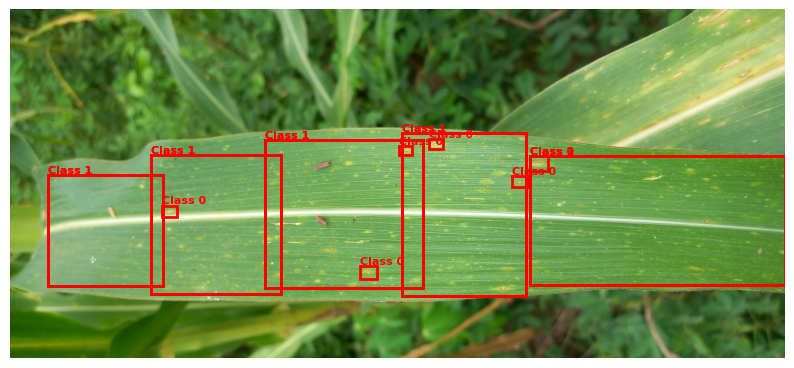

Plotting id_135cn2.jpg with 15 bounding boxes.


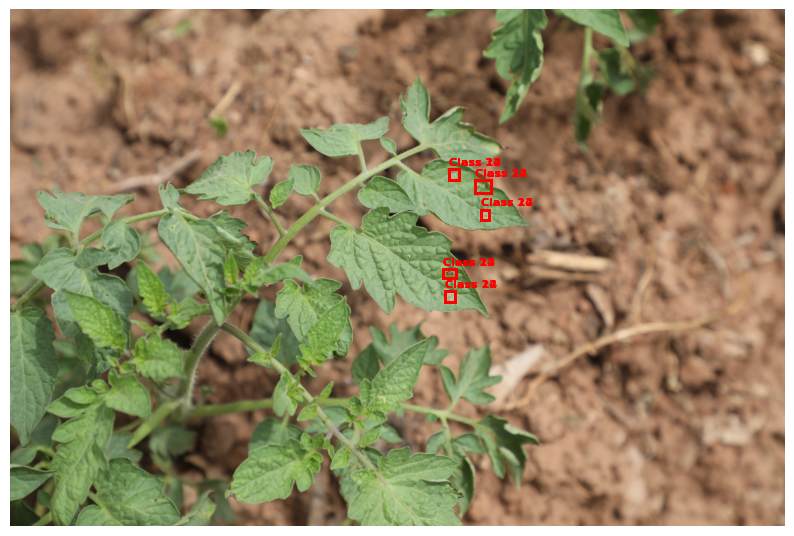

Plotting id_14x5mc.jpg with 29 bounding boxes.


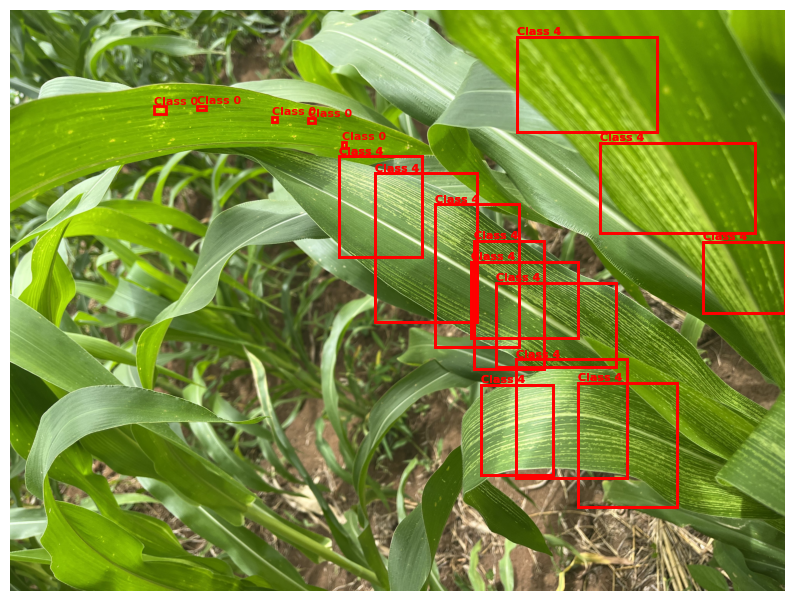

Plotting id_17kcbm.jpg with 14 bounding boxes.


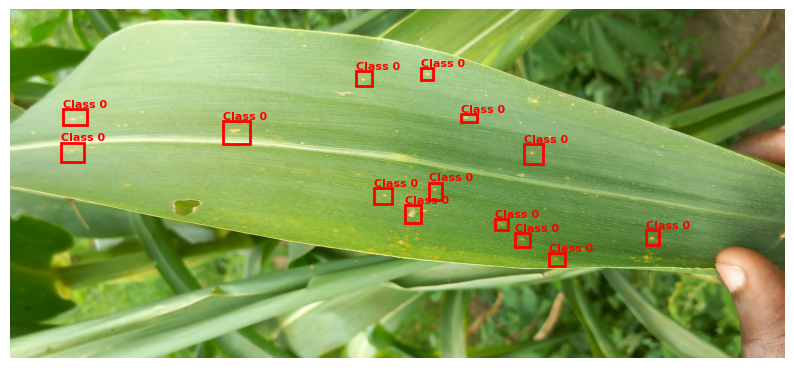

Plotting id_17lyu5.jpg with 5 bounding boxes.


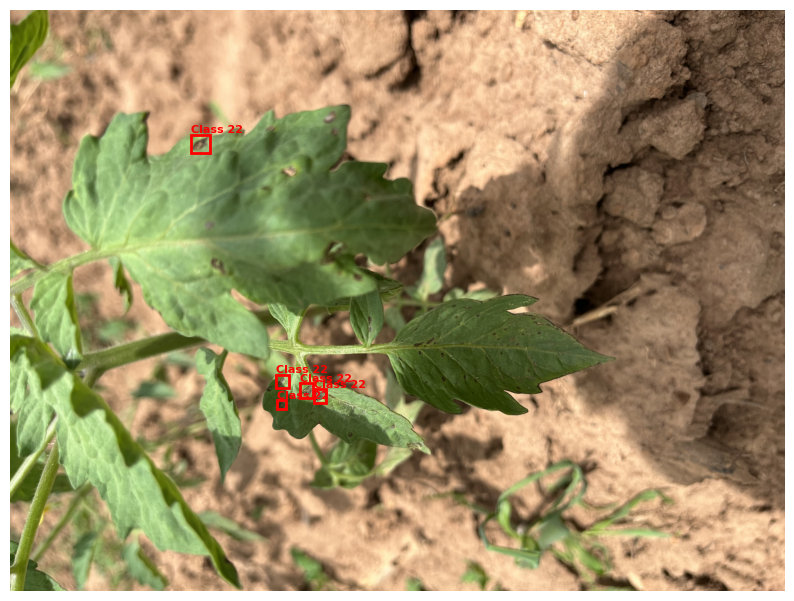

In [17]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = np.array(Image.open(str(image_path)))


    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=8, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:5]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [18]:
# Load a yolo pre-trained model

model = YOLO('yolo11n.pt')

# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=60,                 # Number of epochs
    imgsz=1024,                # Image size (height, width)
    batch=8,                   # Batch size
    device=0,                  # Device to use (0 for the first GPU)
    patience=5)

Ultralytics 8.3.48 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=60, time=None, patience=5, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=No

train: Scanning /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/labels/train... 45111 images, 0 backgrounds, 2547 corrupt: 100%|██████████| 45111/45111 [00:30<00:00, 1491.13it/s]

train: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/train/id_11543h.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/train/id_11gglx.jpg: 5 duplicate labels removed
train: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/train/id_11siot.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/train/id_11zffz.jpg: 10 duplicate labels removed
train: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/train/id_11zffz_564.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1351]
train: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/train/id_127uhh.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/train/id_135cn2.jpg: 5 duplicate labels removed
train: WARNING ⚠️

train: New cache created: /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/labels/train.cache


val: Scanning /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/labels/val... 15037 images, 0 backgrounds, 864 corrupt: 100%|██████████| 15037/15037 [00:09<00:00, 1562.11it/s]

val: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/val/id_11ee1c.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/val/id_11gglx_371.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2628]
val: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/val/id_12q33h.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/val/id_153zcj.jpg: 3 duplicate labels removed
val: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/val/id_15f2s1_431.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0178]
val: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/val/id_15f2s1_791.jpg: ignoring corrupt image/label: negative label values [    -0.2327]
val: WARNING ⚠️ /home/sagemaker-user/Ghana-Crop-Disease-Detection

val: New cache created: /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2024/12/09 09:07:00 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.
2024/12/09 09:07:00 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2024/12/09 09:07:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/12/09 09:07:01 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.11.1 <= statsmodels <= 0.14.3, but the installed version is 0.14.4. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2024/12/09 09:07:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/12/09 09:07:02 WARNING mlflow.utils.autologging_utils: MLflow keras autologging is known to be compatible with 3.0.2 <= keras <= 3.5.0, but the installed version is 3.6.0. If you encounter erro

MLflow: logging run_id(9363aa746d2e4571ad08ab706860b358) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.33G      2.742      7.314       2.32          8       1024: 100%|██████████| 5321/5321 [16:07<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [02:02<00:00,  7.23it/s]


                   all      14173      23095      0.623     0.0136     0.0206    0.00795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.88G       2.64      5.021      2.281         18       1024: 100%|██████████| 5321/5321 [15:41<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:57<00:00,  7.53it/s]


                   all      14173      23095      0.406     0.0403     0.0206    0.00735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      5.26G       2.64      4.753      2.341          8       1024: 100%|██████████| 5321/5321 [15:32<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:52<00:00,  7.90it/s]


                   all      14173      23095      0.535     0.0329     0.0266       0.01

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      4.57G      2.623       4.64      2.338          4       1024: 100%|██████████| 5321/5321 [15:27<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:52<00:00,  7.88it/s]


                   all      14173      23095      0.517      0.047     0.0294      0.011

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.53G      2.565      4.459      2.289          9       1024: 100%|██████████| 5321/5321 [15:27<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:52<00:00,  7.87it/s]


                   all      14173      23095      0.525     0.0463     0.0421     0.0154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      4.12G      2.539      4.348       2.24          5       1024: 100%|██████████| 5321/5321 [15:26<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:53<00:00,  7.83it/s]


                   all      14173      23095      0.559     0.0566     0.0395     0.0146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.35G      2.508      4.285      2.225         31       1024: 100%|██████████| 5321/5321 [15:26<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:56<00:00,  7.63it/s]


                   all      14173      23095      0.499     0.0534     0.0479     0.0184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      5.92G      2.495      4.222      2.209          5       1024: 100%|██████████| 5321/5321 [15:24<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:54<00:00,  7.75it/s]


                   all      14173      23095      0.561     0.0684     0.0534     0.0212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.37G      2.476      4.169      2.189          8       1024: 100%|██████████| 5321/5321 [15:27<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:53<00:00,  7.79it/s]


                   all      14173      23095      0.509     0.0812     0.0596     0.0229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.19G      2.462       4.14      2.182         11       1024: 100%|██████████| 5321/5321 [15:26<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:53<00:00,  7.77it/s]


                   all      14173      23095      0.526     0.0909     0.0655     0.0274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.34G      2.451      4.111      2.169         19       1024: 100%|██████████| 5321/5321 [15:26<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:54<00:00,  7.71it/s]


                   all      14173      23095      0.525     0.0901     0.0646      0.026

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      4.57G       2.44      4.077      2.161         10       1024: 100%|██████████| 5321/5321 [15:26<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:55<00:00,  7.69it/s]


                   all      14173      23095      0.503      0.103     0.0879     0.0325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.35G      2.436      4.051      2.149          8       1024: 100%|██████████| 5321/5321 [15:27<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:53<00:00,  7.78it/s]


                   all      14173      23095      0.421      0.108     0.0664     0.0272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      4.47G      2.421      4.034      2.152         32       1024: 100%|██████████| 5321/5321 [15:26<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:54<00:00,  7.71it/s]


                   all      14173      23095      0.464       0.11     0.0717      0.029

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      4.58G       2.42      3.996      2.135         10       1024: 100%|██████████| 5321/5321 [15:25<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:54<00:00,  7.76it/s]


                   all      14173      23095      0.478       0.11     0.0753     0.0308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      4.29G      2.414      4.001      2.132         13       1024: 100%|██████████| 5321/5321 [15:26<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:57<00:00,  7.52it/s]


                   all      14173      23095       0.43      0.114      0.078     0.0317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.74G      2.402      3.964       2.13          8       1024: 100%|██████████| 5321/5321 [15:24<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:56<00:00,  7.61it/s]


                   all      14173      23095      0.493      0.113     0.0803      0.033
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 12, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

17 epochs completed in 4.947 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n summary (fused): 238 layers, 2,586,637 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 886/886 [01:40<00:00,  8.83it/s]


                   all      14173      23095      0.503      0.103     0.0878     0.0325
Corn_Cercospora_Leaf_Spot        209       1676      0.184      0.675      0.378      0.138
      Corn_Common_Rust        784       1165      0.203      0.188      0.104     0.0411
          Corn_Healthy        679       1035      0.194     0.0937     0.0697     0.0233
Corn_Northern_Leaf_Blight         85        126          1          0      0.504      0.151
           Corn_Streak       1599       2249      0.202      0.137     0.0731     0.0255
 Pepper_Bacterial_Spot       1072       1397       0.17      0.105     0.0451     0.0119
     Pepper_Cercospora        270        328          1          0      0.019    0.00591
   Pepper_Early_Blight         51         76          1          0          0          0
       Pepper_Fusarium        289        363       0.15     0.0992      0.043     0.0138
        Pepper_Healthy        420        547      0.139      0.322      0.125     0.0494
    Pepper_Late

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3209e7ccd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.0420

In [19]:
# Validate the model on the validation set

model = YOLO('/home/sagemaker-user/Ghana-Crop-Disease-Detection/runs/detect/train2/weights/best.pt')
results = model.val(data='data.yaml')


FileNotFoundError: [Errno 2] No such file or directory: '/home/sagemaker-user/Ghana-Crop-Disease-Detection/runs/detect/train2/weights/best.pt'

In [37]:
# Validate the model on the validation set
model = YOLO('/home/sagemaker-user/Ghana-Crop-Disease-Detection/runs/detect/train2/weights/best.pt')
results = model.val()

Ultralytics 8.3.40 🚀 Python-3.11.10 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14918MiB)
YOLO11n summary (fused): 238 layers, 2,586,637 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/labels/val.cache... 1226 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1226/1226 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 77/77 [00:15<00:00,  4.98it/s]


                   all       1226      10252      0.401      0.366      0.326      0.145
Corn_Cercospora_Leaf_Spot        202       1600      0.454      0.519       0.46      0.185
      Corn_Common_Rust         79        442       0.45      0.317      0.331      0.141
          Corn_Healthy         63        415      0.413      0.306      0.309      0.117
Corn_Northern_Leaf_Blight         12         25      0.156       0.24       0.19     0.0444
           Corn_Streak         87        804      0.326      0.422      0.317      0.116
 Pepper_Bacterial_Spot        132        476      0.484      0.244      0.274     0.0679
     Pepper_Cercospora         41        121       0.46      0.331      0.268      0.114
   Pepper_Early_Blight          2         15          1          0          0          0
       Pepper_Fusarium         52        123      0.494      0.659      0.633      0.251
        Pepper_Healthy         68        184      0.345      0.821      0.636      0.308
    Pepper_Late

In [ ]:
# Load the trained YOLO model
model = YOLO('/home/sagemaker-user/Ghana-Crop-Disease-Detection/runs/detect/train2/weights/best.pt')

# Path to the test images directory
test_dir_path = '/home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test'

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
# Default settings
default_bbox = [0, 0, 100, 100]  # Example default bounding box
default_class_id = -1  # Default class ID for "no detection"
default_class_name = "Corn_Cercospora_Leaf_Spot"  # Default class name
default_confidence = 1.0  # High confidence for the default case

all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)
    
    # Initialize placeholders
    boxes = []
    classes = []
    confidences = []
    
    # If detections are made
    if results and len(results[0].boxes) > 0:
        # Extract bounding boxes, confidence scores, and class labels
        boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
        classes = results[0].boxes.cls.tolist()  # Class indices
        confidences = results[0].boxes.conf.tolist()  # Confidence scores
        # Class names dictionary
        names = results[0].names
    else:
        # Assign default prediction
        print("no detection")
        boxes = [default_bbox]
        classes = [default_class_id]
        confidences = [default_confidence]
        names = {default_class_id: default_class_name}  # Include the default class name in the names dictionary
    
    # Iterate through the results for this image
    for box, cls, conf in zip(boxes, classes, confidences):
        x1, y1, x2, y2 = box
        detected_class = names[int(cls)]  # Get the class name from the names dictionary

        # Add the result to the all_data list
        all_data.append({
            'Image_ID': image_file,
            'class': detected_class,
            'confidence': conf,
            'ymin': y1,
            'xmin': x1,
            'ymax': y2,
            'xmax': x2
        })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

  0%|          | 0/2101 [00:00<?, ?it/s]


image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_128pxx.jpg: 704x1024 5 Tomato_Septorias, 11.8ms
Speed: 6.2ms preprocess, 11.8ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_12jbci.jpg: 704x1024 1 Corn_Streak, 11.4ms
Speed: 4.9ms preprocess, 11.4ms inference, 0.9ms postprocess per image at shape (1, 3, 704, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_143s4o.jpg: 480x1024 6 Corn_Cercospora_Leaf_Spots, 9.0ms
Speed: 4.3ms preprocess, 9.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/test/id_14tfmb.jpg: 768x1024 2 Pepper_Fusariums, 12.3ms
Speed: 7.1ms preprocess, 12.3ms inference, 1.0ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/Ghana-Crop-Disease-Detection/dataset/images/t

In [16]:
# check for missing image id from the sub compared to the initial submission
# no_pred = set(sub['Image_ID']).symmetric_difference(set(test['Image_ID']))

# assign it a default using the last prediction
len(sub['Image_ID'])
# default = sub.tail(1)

# default['Image_ID'] = _pred

# sub.concat(default)


11645

In [20]:
sub.head()

Image_ID            class  confidence        ymin         xmin  \
0  id_128pxx.jpg  Tomato_Septoria    0.450659   48.342171  1055.538818   
1  id_128pxx.jpg  Tomato_Septoria    0.403076  648.499817   970.331116   
2  id_128pxx.jpg  Tomato_Septoria    0.293224    6.501172   468.182861   
3  id_128pxx.jpg  Tomato_Septoria    0.257973  675.015381   907.879883   
4  id_128pxx.jpg  Tomato_Septoria    0.252478  874.591858   970.120972   

         ymax         xmax  
0  100.183250  1113.381836  
1  690.717957  1011.601440  
2   42.007938   528.101135  
3  713.100403   943.654358  
4  918.472473  1008.744812

In [21]:
sub['class'].value_counts()

class
Corn_Cercospora_Leaf_Spot    2878
Tomato_Healthy               1675
Tomato_Septoria              1324
Corn_Streak                   942
Tomato_Late_Blight            882
Tomato_Early_Blight           728
Pepper_Healthy                533
Tomato_Fusarium               468
Pepper_Leaf_Curl              388
Corn_Common_Rust              279
Pepper_Fusarium               249
Corn_Healthy                  247
Pepper_Bacterial_Spot         233
Tomato_Leaf_Curl              212
Pepper_Septoria               193
Pepper_Leaf_Blight            131
Pepper_Cercospora             120
Corn_Northern_Leaf_Blight      91
Tomato_Bacterial_Spot          57
Tomato_Mosaic                  10
Pepper_Late_Blight              5
Name: count, dtype: int64

In [22]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('benchmark_1_submission.csv', index = False)